## Importing Important Liraries

In [1]:
import os
import tarfile
import urllib.request
import tensorflow as tf

print (tf. __version__ )


2025-04-28 20:32:39.239206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745872359.575054      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745872359.674378      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## Downloading the Stack Overflow Dataset

In [2]:
tar_path = '/kaggle/input/stack-overflow/stack_overflow_16k.tar.gz'




In [3]:
import os
print(os.listdir('/kaggle/working'))

['__notebook__.ipynb']


In [4]:
# Path where your uploaded file is located
stack_overflow_tar = '/kaggle/working/stack_overflow_16k.tar.gz'

# 1. Extract the tar.gz file if not already extracted
if not os.path.exists('/kaggle/input/stack-overflow'):
    with tarfile.open(stack_overflow_tar, 'r:gz') as tar:
        tar.extractall(path='/kaggle/working/')
    print("Extraction complete!")
else:
    print("Already extracted.")

Already extracted.


stack_overflow/
 ├── train/
 │    ├── python/
 │    ├── javascript/
 │    ├── java/
 │    └── csharp/
 └── test/


## Preparing the dataset

In [5]:
# 2. Set batch size and seed
batch_size = 32
seed = 42

# 3. Create training, validation, and test datasets
train_ds = tf.keras.utils.text_dataset_from_directory(
    '/kaggle/input/stack-overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/kaggle/input/stack-overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '/kaggle/input/stack-overflow/test',
    batch_size=batch_size
)

print("Datasets prepared successfully!")

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2025-04-28 20:33:04.933833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.
Datasets prepared successfully!


# Updating the Model Architecture


In [6]:
from tensorflow.keras import layers

# Create a text vectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels) for adapt()
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Build the model
model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(max_features + 1, 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)  
])

# Model Compilation

updating the model loss function and metrics

In [7]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])  # Changed from BinaryAccuracy to accuracy

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training the model

The output will reflect multi-class metrics

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2989 - loss: 1.3806 - val_accuracy: 0.3925 - val_loss: 1.3632
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3850 - loss: 1.3526 - val_accuracy: 0.4331 - val_loss: 1.3168
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4733 - loss: 1.2949 - val_accuracy: 0.5575 - val_loss: 1.2370
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5581 - loss: 1.2166 - val_accuracy: 0.6306 - val_loss: 1.1415
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6265 - loss: 1.1224 - val_accuracy: 0.6769 - val_loss: 1.0604
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6688 - loss: 1.0402 - val_accuracy: 0.6875 - val_loss: 0.9786
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6857 - loss: 0.9689 - val_accuracy: 0.7319 - val_loss: 0.9193
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7192 - loss: 0.8953 - val_accu

# Evaluating the model

In [10]:
test_loss, test_acc = model.evaluate(test_ds)

print("\n Test Loss: ", test_loss)
print("\n Test Accuracy: ", test_acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7083 - loss: 0.8273

 Test Loss:  0.8230355978012085

 Test Accuracy:  0.7122499942779541


# Creating a plot of accuracy and loss over time

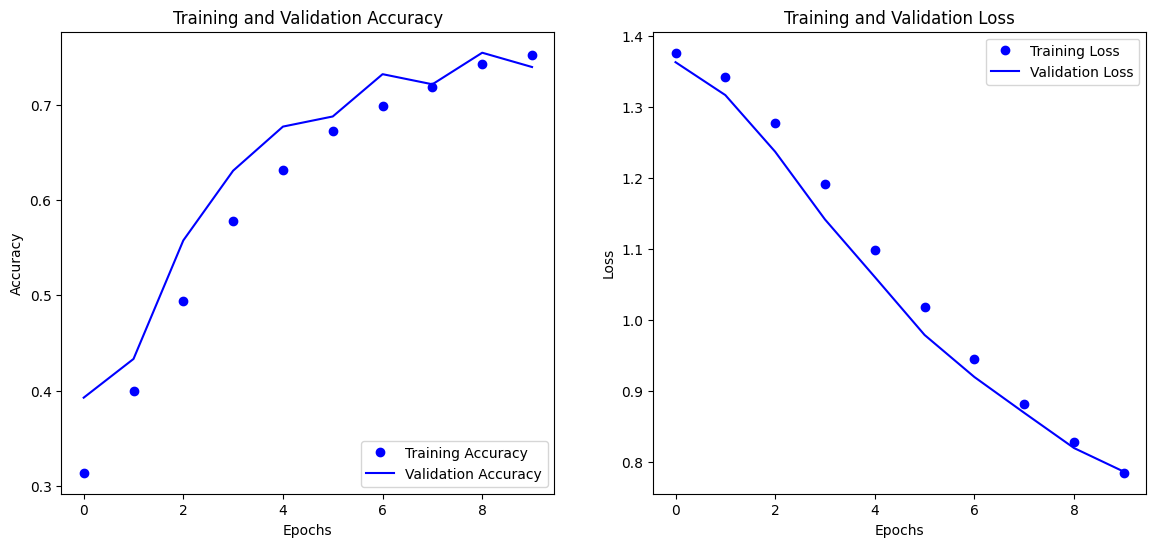

In [11]:
import matplotlib.pyplot as plt

#Extract history values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plotting the curves
plt.figure(figsize=(14,6))

#Accuracy plot
plt.subplot(1, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
# "b" is for "blue dot"
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
# "bo" is for "blue dot"
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
# "b" is for "blue dot"
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data